In [1]:
from wmi_backend_grid import *
from wmi_decompositions import *

import numpy as np
import scipy.linalg

from qiskit import *
from qiskit.transpiler import Layout
from qiskit.quantum_info.operators import Operator

from qiskit.visualization import *
from util import *

### General Parameters

In [2]:
u = 1
t = 1
delta_t = 1
n = 1

In [3]:
lattice_size = (2,2)
Nx, Ny = lattice_size
num_sites = Nx*Ny

### Reference Hamiltonian

In [4]:
def create_ref_fh_hamiltonian(n=1):
    """
    Creates a reference Hamiltonian of the Fermi Hubbard model using Qiskit.

    Args:
        n (int): Number of Trotter steps. This is directly passed to the reps parameter

    Returns:
        The matrix representation of the reference Hamiltonian.
    """
    from qiskit.opflow import X, Y, Z, I, PauliTrotterEvolution, PauliSumOp
    from qiskit.circuit import Parameter

    # 1↑ 2↑ 3↑ 4↑ 1↓ 2↓ 3↓ 4↓

    # interaction term
    A = 1/2*Z
    H1 = (A^I^I^I^A^I^I^I) + (I^A^I^I^I^A^I^I) + (I^I^A^I^I^I^A^I) + (I^I^I^A^I^I^I^A)

    # hopping term
    H2 = -2*t*(
                (X^I^X^I^I^I^I^I) + (Y^I^Y^I^I^I^I^I)
                +(I^X^I^X^I^I^I^I) + (I^Y^I^Y^I^I^I^I)
                +(I^I^I^I^X^X^I^I) + (I^I^I^I^Y^Y^I^I)
                +(I^I^I^I^I^I^X^X) + (I^I^I^I^I^I^Y^Y)

                +(X^X^I^I^Z^Z^I^I) + (Y^Y^I^I^Z^Z^I^I)
                +(I^I^X^X^I^I^Z^Z) + (I^I^Y^Y^I^I^Z^Z)
                +(Z^I^Z^I^X^I^X^I) + (Z^I^Z^I^Y^I^Y^I)
                +(I^Z^I^Z^I^X^I^X) + (I^Z^I^Z^I^Y^I^Y)
                )

    hamiltonian = H1 + H2
    # evolution operator
    evo_time = Parameter('t')
    evolution_op = (evo_time*hamiltonian).exp_i()
    # into circuit
    num_time_slices = n
    trotterized_op = PauliTrotterEvolution(
                        trotter_mode='suzuki',
                        reps=num_time_slices).convert(evolution_op)
    circuit = trotterized_op.to_circuit()
    param_bind = {
        evo_time: 1,
    }
    #ref_circ = trotterized_op.bind_parameters(param_bind).eval().to_circuit_op().to_circuit()
    ref_matrix = trotterized_op.bind_parameters(param_bind).eval().to_matrix()
    return ref_matrix

### Trotter step

In [5]:
def add_trotter_steps(trotter_circuit, spin_up, spin_down, n=1):
    """
    Adds n Trotter steps to the given quantum circuit.

    Args:
        trotter_circuit: The Qiskit QuantumCircuit to which the Trotter steps are added.
        spin_up: The qubit register containing the up spins.
        spin_down: The qubit register containing the down spins.
        n: The number of Trotter steps that are added.
    """
    for _ in range(n):
        #############
        # H_1
        ############
        lam = u*delta_t/(4*n)
        for i in range(num_sites):
            trotter_circuit.rzz(lam, spin_up[i], spin_down[i])

        trotter_circuit.barrier(spin_up, spin_down)


        #############
        # H_2
        ############
        theta = 4*t*delta_t/n
        eta = 0
        hoppings = [(spin_up[0], spin_up[2]), (spin_up[1], spin_up[3]), (spin_down[0], spin_down[1]), (spin_down[2], spin_down[3])]
        for hop in hoppings:
            trotter_circuit.append(ParamISwap(theta, eta), hop)

        trotter_circuit.barrier(spin_up, spin_down)


        #############
        # H_3
        ############

        swaps = [(spin_up[0], spin_down[0]), (spin_up[1], spin_down[1]), (spin_up[2], spin_down[2]), (spin_up[3], spin_down[3])]
        for swap in swaps:
            trotter_circuit.append(fSwap(), swap)

        trotter_circuit.barrier(spin_up, spin_down)

        theta = 8*t*delta_t/n
        eta = 0
        hoppings = [(spin_up[0], spin_up[2]), (spin_up[1], spin_up[3]), (spin_down[0], spin_down[1]), (spin_down[2], spin_down[3])]
        for hop in hoppings:
            trotter_circuit.append(ParamISwap(theta, eta), hop)

        trotter_circuit.barrier(spin_up, spin_down)

        # swap back
        swaps = [(spin_up[0], spin_down[0]), (spin_up[1], spin_down[1]), (spin_up[2], spin_down[2]), (spin_up[3], spin_down[3])]
        for swap in swaps:
            trotter_circuit.append(fSwap(), swap)

        trotter_circuit.barrier(spin_up, spin_down)


        #############
        # H_2
        ############
        theta = 4*t*delta_t/n
        eta = 0
        hoppings = [(spin_up[0], spin_up[2]), (spin_up[1], spin_up[3]), (spin_down[0], spin_down[1]), (spin_down[2], spin_down[3])]
        for hop in hoppings:
            trotter_circuit.append(ParamISwap(theta, eta), hop)

        trotter_circuit.barrier(spin_up, spin_down)
        

        #############
        # H_1
        ############
        lam = u*delta_t/(4*n)
        for i in range(num_sites):
            trotter_circuit.rzz(lam, spin_up[i], spin_down[i])

        trotter_circuit.barrier(spin_up, spin_down)


# Single Trotter step

In [6]:
spin_up = QuantumRegister(num_sites, '↑')
spin_down = QuantumRegister(num_sites, '↓')
single_step_circuit = QuantumCircuit(spin_up, spin_down)

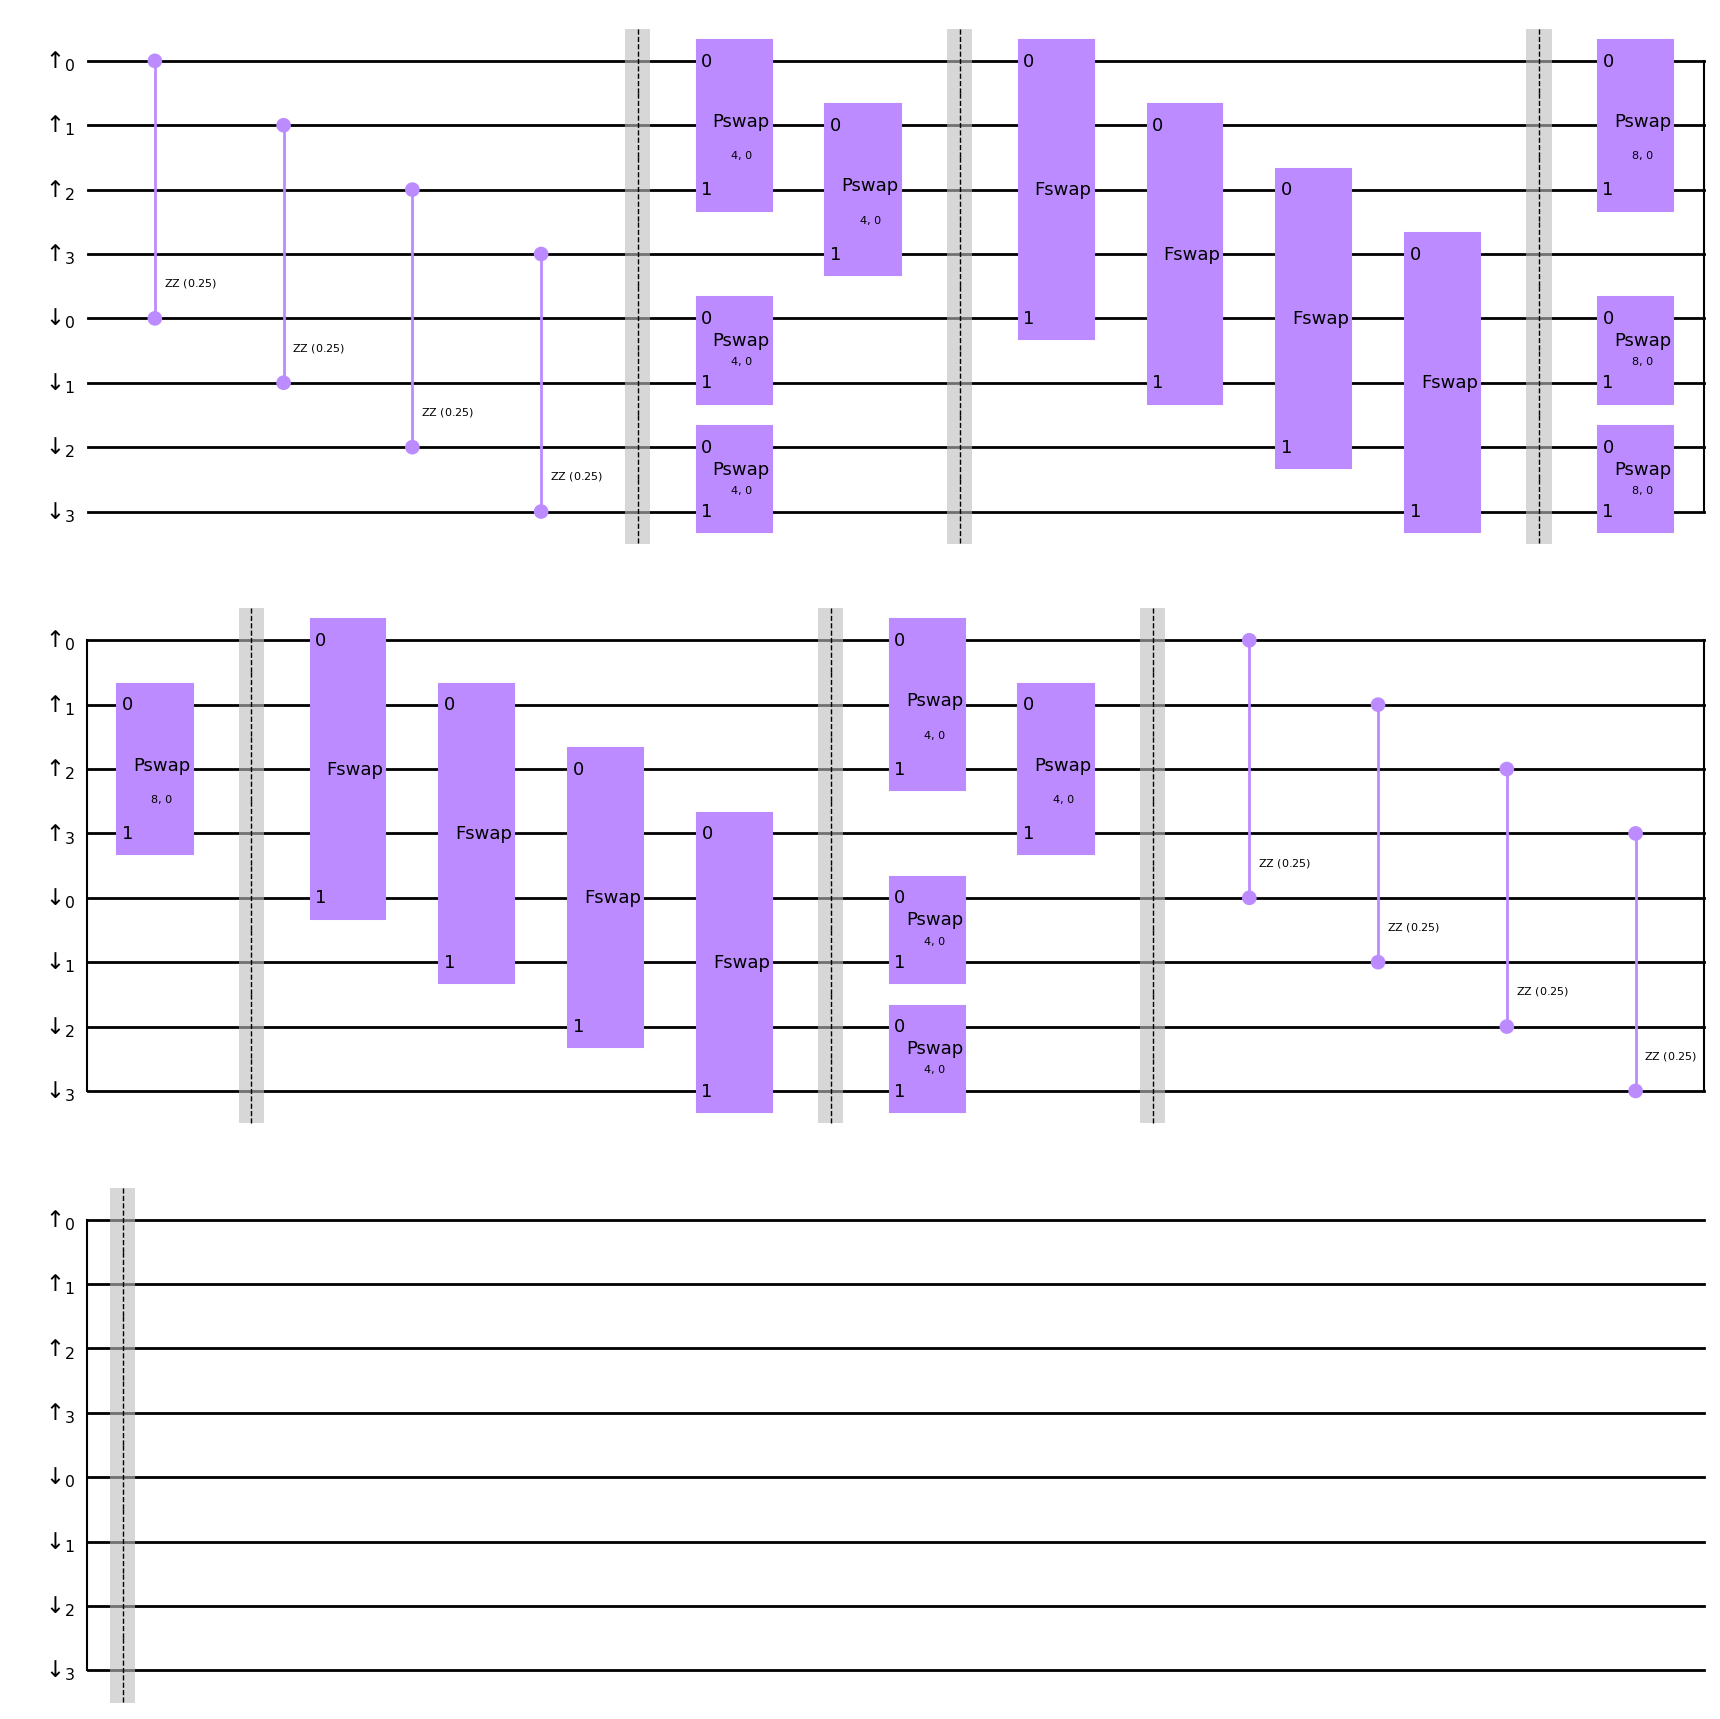

In [7]:
add_trotter_steps(single_step_circuit, spin_up, spin_down, 1)
single_step_circuit.draw("mpl")

In [8]:
ref_matrix = create_ref_fh_hamiltonian(1)
single_step_matrix = circuit2matrix(single_step_circuit, keep_qiskit_ordering=False)

C:\Users\thilo\AppData\Local\Temp\ipykernel_10384\2725882883.py:11: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import X, Y, Z, I, PauliTrotterEvolution, PauliSumOp
C:\Users\thilo\AppData\Local\Temp\ipykernel_10384\2725882883.py:39: DeprecationWarning: The class ``qiskit.opflow.evolutions.pauli_trotter_evolution.PauliTrotterEvolution`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  trotterized_op = PauliTrotterEvolution(


In [9]:
print("Error: " + str(np.linalg.norm(ref_matrix - single_step_matrix, 2)))

Error: 5.864310369443015e-15


### Mapping

In [10]:
backend = WMIBackendGrid()

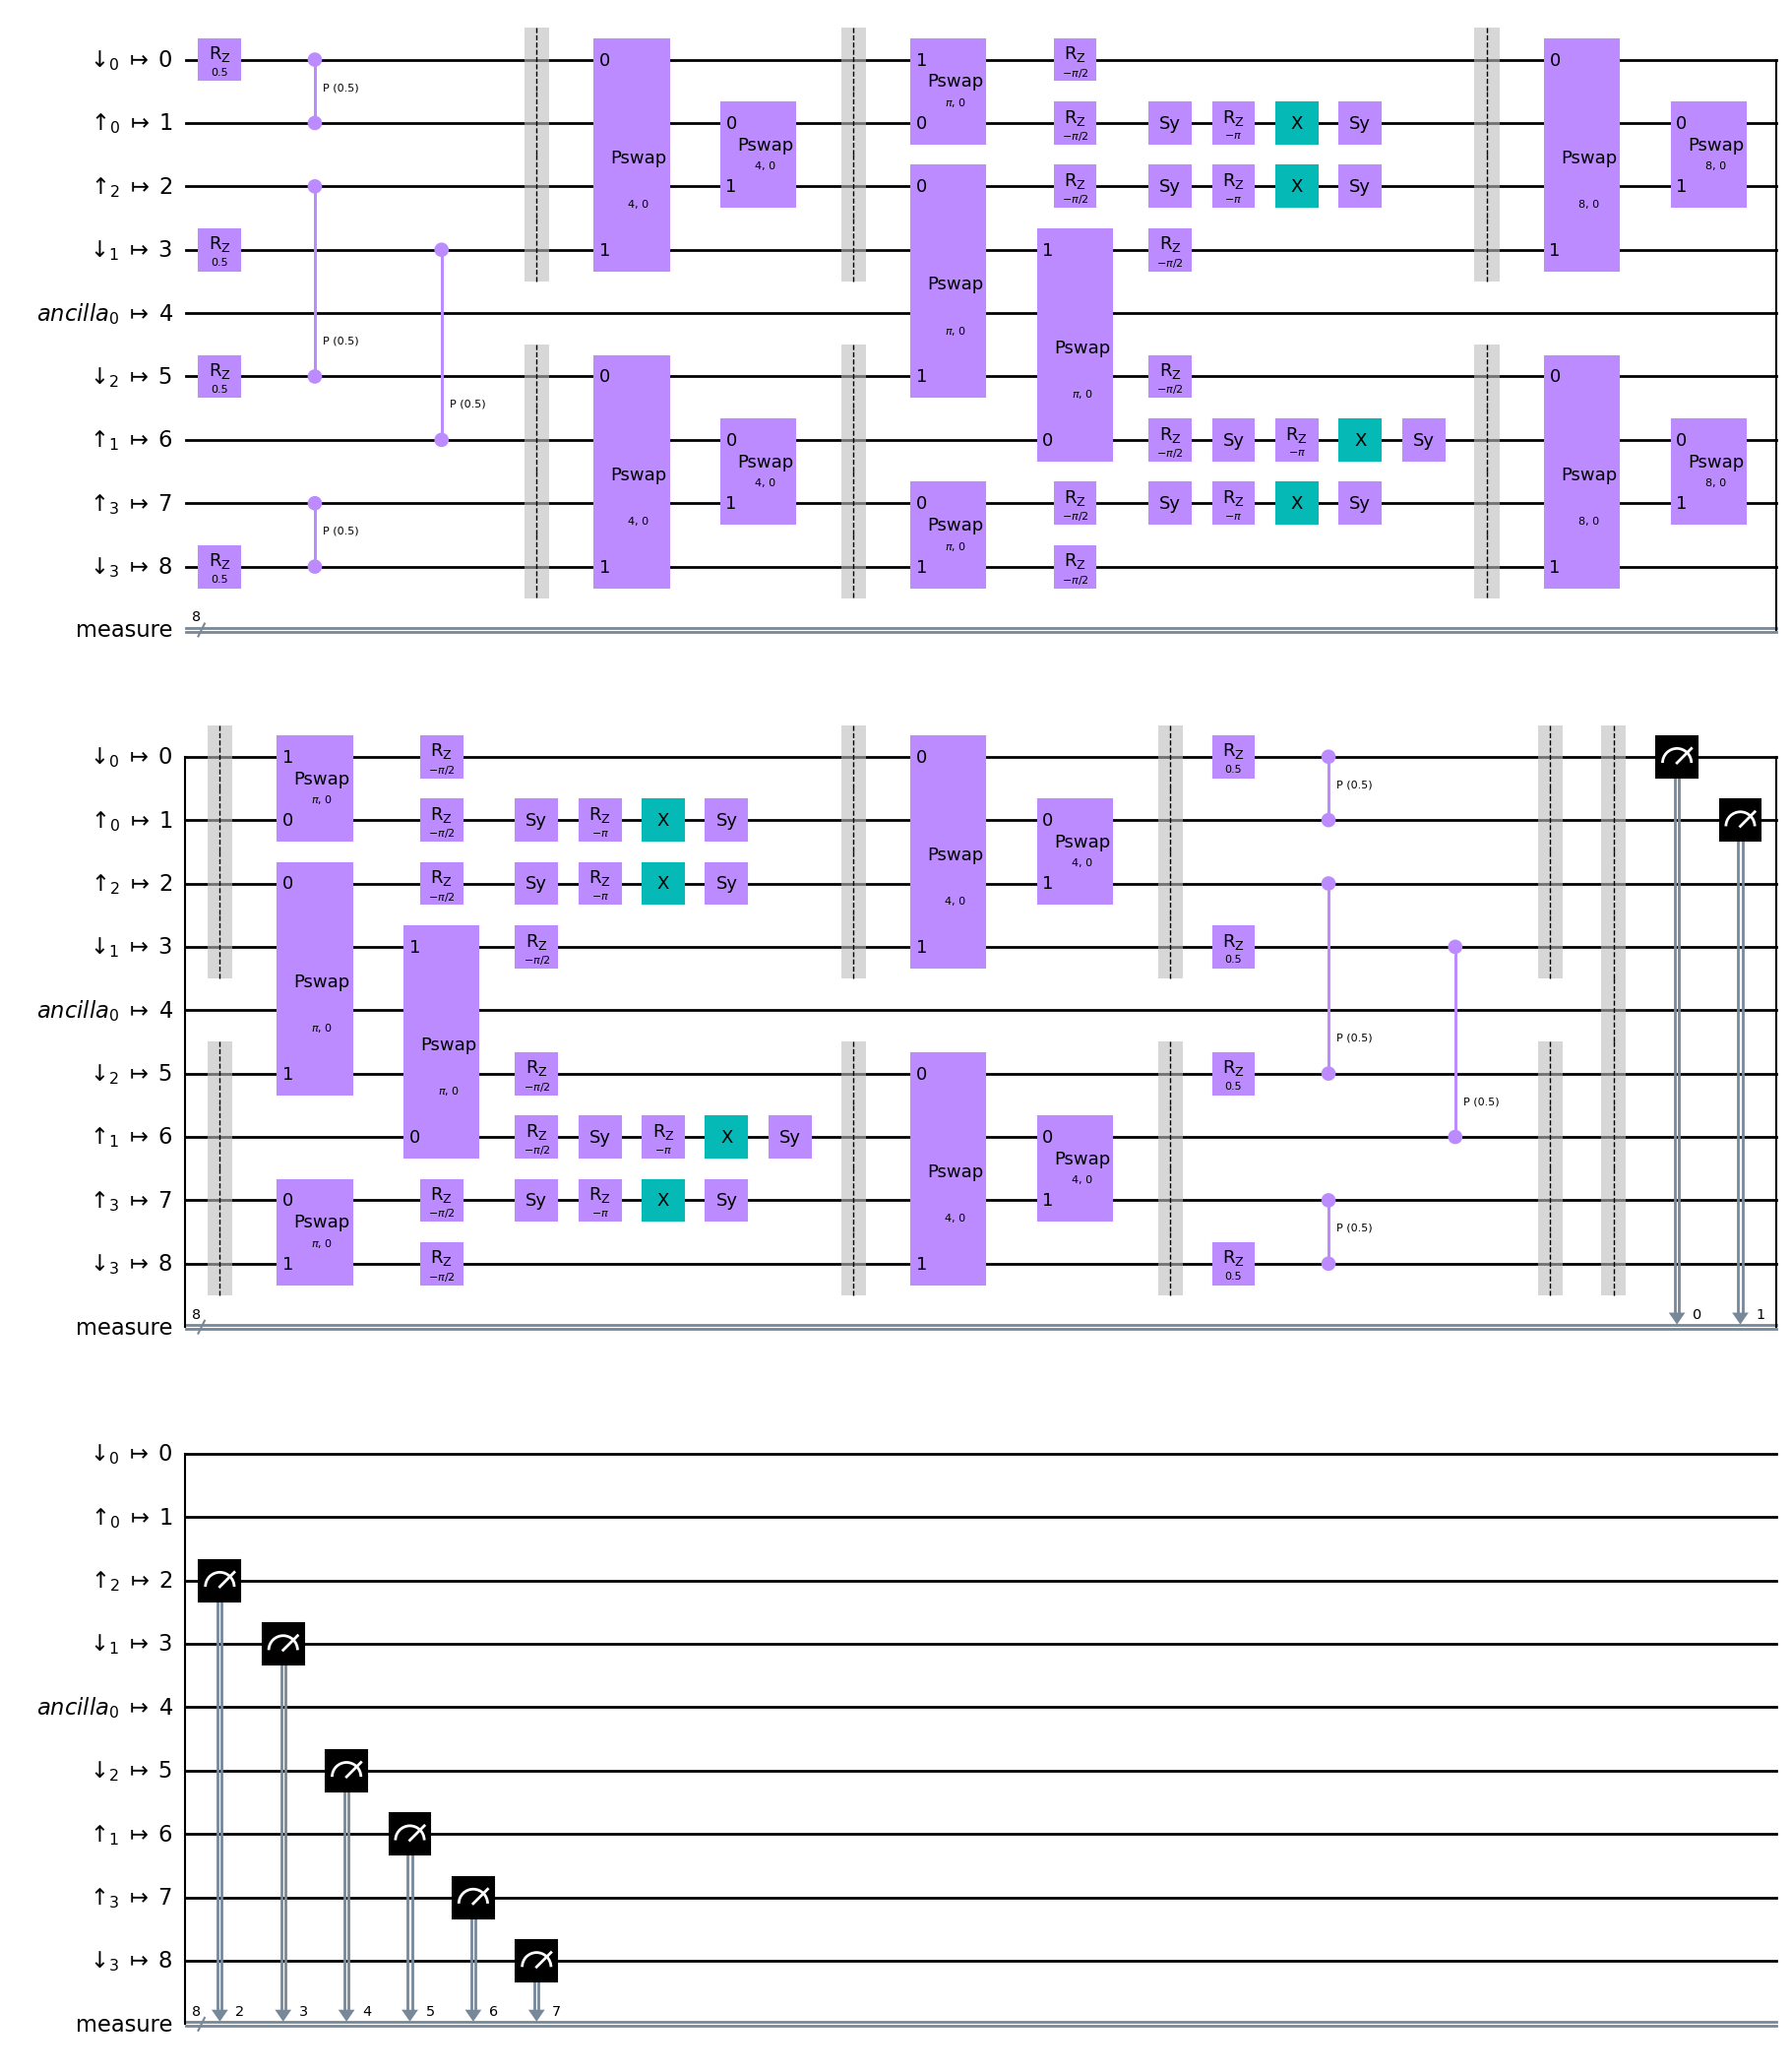

In [11]:
initial_layout = Layout({
    spin_up[0]:   0,
    spin_down[0]: 1,
    spin_up[1]:   2,
    spin_down[1]: 5,
    spin_up[2]:   3,
    spin_down[2]: 6,
    spin_up[3]:   7,
    spin_down[3]: 8,
})

# Transpile to WMI hardware
transpiled_circuit = transpile(
    single_step_circuit,
    backend=backend,
    optimization_level=3,
    #initial_layout=initial_layout
)
transpiled_circuit.measure_active()
transpiled_circuit.draw("mpl")

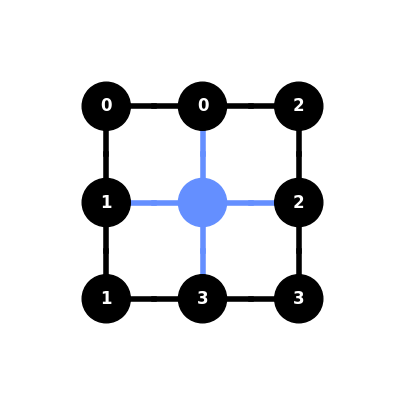

In [12]:
qubit_coordinates = [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0], [2, 1], [2, 2]]
plot_circuit_layout(transpiled_circuit, backend, view="virtual", qubit_coordinates=qubit_coordinates)

# Multiple Trotter steps

In [13]:
spin_up = QuantumRegister(num_sites, '↑')
spin_down = QuantumRegister(num_sites, '↓')
trotter_circuit = QuantumCircuit(spin_up, spin_down)

In [14]:
add_trotter_steps(trotter_circuit, spin_up, spin_down, 100)
#trotter_circuit.draw("mpl")

In [15]:
ref_matrix = create_ref_fh_hamiltonian(100)
trotter_matrix = circuit2matrix(trotter_circuit, keep_qiskit_ordering=False)

C:\Users\thilo\AppData\Local\Temp\ipykernel_10384\2725882883.py:39: DeprecationWarning: The class ``qiskit.opflow.evolutions.pauli_trotter_evolution.PauliTrotterEvolution`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  trotterized_op = PauliTrotterEvolution(


In [16]:
print("Error: " + str(np.linalg.norm(ref_matrix - trotter_matrix, 2)))

Error: 5.792867747434299e-13


# Control-free implementation

In [17]:
spin_up = QuantumRegister(num_sites, '↑')
spin_down = QuantumRegister(num_sites, '↓')
aux = QuantumRegister(1, "aux")
ctrl_free_circuit = QuantumCircuit(aux, spin_up, spin_down)

In [18]:
n = 100
for _ in range(n):
    #############
    # K1
    ############
    ctrl_free_circuit.cx(aux, spin_up[1], ctrl_state="0")
    ctrl_free_circuit.cx(aux, spin_up[2], ctrl_state="0")
    ctrl_free_circuit.cx(aux, spin_down[0], ctrl_state="0")
    ctrl_free_circuit.cx(aux, spin_down[3], ctrl_state="0")

    ctrl_free_circuit.barrier(spin_up, spin_down)


    #############
    # H_1
    ############
    lam = u*delta_t/(4*n)
    for i in range(num_sites):
        ctrl_free_circuit.rzz(lam, spin_up[i], spin_down[i])

    ctrl_free_circuit.barrier(spin_up, spin_down)


    #############
    # K1
    ############
    ctrl_free_circuit.cx(aux, spin_up[1], ctrl_state="0")
    ctrl_free_circuit.cx(aux, spin_up[2], ctrl_state="0")
    ctrl_free_circuit.cx(aux, spin_down[0], ctrl_state="0")
    ctrl_free_circuit.cx(aux, spin_down[3], ctrl_state="0")

    ctrl_free_circuit.barrier(spin_up, spin_down)


    #############
    # K2
    ############
    ctrl_free_circuit.cz(aux, spin_up[1], ctrl_state="0")
    ctrl_free_circuit.cz(aux, spin_up[2], ctrl_state="0")
    ctrl_free_circuit.cz(aux, spin_down[0], ctrl_state="0")
    ctrl_free_circuit.cz(aux, spin_down[3], ctrl_state="0")

    ctrl_free_circuit.barrier(spin_up, spin_down)


    #############
    # H_2
    ############
    theta = 4*t*delta_t/n
    eta = 0
    hoppings = [(spin_up[0], spin_up[2]), (spin_up[1], spin_up[3]), (spin_down[0], spin_down[1]), (spin_down[2], spin_down[3])]
    for hop in hoppings:
        ctrl_free_circuit.append(ParamISwap(theta, eta), hop)

    ctrl_free_circuit.barrier(spin_up, spin_down)


    #############
    # H_3
    ############

    swaps = [(spin_up[0], spin_down[0]), (spin_up[1], spin_down[1]), (spin_up[2], spin_down[2]), (spin_up[3], spin_down[3])]
    for swap in swaps:
        ctrl_free_circuit.append(fSwap(), swap)

    ctrl_free_circuit.barrier(spin_up, spin_down)

    theta = 8*t*delta_t/n
    eta = 0
    hoppings = [(spin_up[0], spin_up[2]), (spin_up[1], spin_up[3]), (spin_down[0], spin_down[1]), (spin_down[2], spin_down[3])]
    for hop in hoppings:
        ctrl_free_circuit.append(ParamISwap(theta, eta), hop)

    ctrl_free_circuit.barrier(spin_up, spin_down)

    # swap back
    swaps = [(spin_up[0], spin_down[0]), (spin_up[1], spin_down[1]), (spin_up[2], spin_down[2]), (spin_up[3], spin_down[3])]
    for swap in swaps:
        ctrl_free_circuit.append(fSwap(), swap)

    ctrl_free_circuit.barrier(spin_up, spin_down)


    #############
    # H_2
    ############
    theta = 4*t*delta_t/n
    eta = 0
    hoppings = [(spin_up[0], spin_up[2]), (spin_up[1], spin_up[3]), (spin_down[0], spin_down[1]), (spin_down[2], spin_down[3])]
    for hop in hoppings:
        ctrl_free_circuit.append(ParamISwap(theta, eta), hop)

    ctrl_free_circuit.barrier(spin_up, spin_down)


    #############
    # K2
    ############
    ctrl_free_circuit.cz(aux, spin_up[1], ctrl_state="0")
    ctrl_free_circuit.cz(aux, spin_up[2], ctrl_state="0")
    ctrl_free_circuit.cz(aux, spin_down[0], ctrl_state="0")
    ctrl_free_circuit.cz(aux, spin_down[3], ctrl_state="0")

    ctrl_free_circuit.barrier(spin_up, spin_down)
    

    #############
    # K1
    ############
    ctrl_free_circuit.cx(aux, spin_up[1], ctrl_state="0")
    ctrl_free_circuit.cx(aux, spin_up[2], ctrl_state="0")
    ctrl_free_circuit.cx(aux, spin_down[0], ctrl_state="0")
    ctrl_free_circuit.cx(aux, spin_down[3], ctrl_state="0")

    ctrl_free_circuit.barrier(spin_up, spin_down)
    

    #############
    # H_1
    ############
    lam = u*delta_t/(4*n)
    for i in range(num_sites):
        ctrl_free_circuit.rzz(lam, spin_up[i], spin_down[i])

    ctrl_free_circuit.barrier(spin_up, spin_down)

    #############
    # K1
    ############
    ctrl_free_circuit.cx(aux, spin_up[1], ctrl_state="0")
    ctrl_free_circuit.cx(aux, spin_up[2], ctrl_state="0")
    ctrl_free_circuit.cx(aux, spin_down[0], ctrl_state="0")
    ctrl_free_circuit.cx(aux, spin_down[3], ctrl_state="0")

    ctrl_free_circuit.barrier(spin_up, spin_down)


In [19]:
ref_trotter = create_ref_fh_hamiltonian(100)
ref_matrix = scipy.linalg.block_diag(ref_trotter.conjugate().transpose(), ref_trotter)
ctrl_free_matrix = circuit2matrix(ctrl_free_circuit, keep_qiskit_ordering=False)

C:\Users\thilo\AppData\Local\Temp\ipykernel_10384\2725882883.py:39: DeprecationWarning: The class ``qiskit.opflow.evolutions.pauli_trotter_evolution.PauliTrotterEvolution`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  trotterized_op = PauliTrotterEvolution(


In [20]:
print("Error: " + str(np.linalg.norm(ref_matrix - ctrl_free_matrix, 2)))

Error: 5.792867747434299e-13
